# Direct Fidelity Estimation example

In [1]:
from pyquil.paulis import ID
from pyquil.gates import I, X, MEASURE, H, CZ, RY
from pyquil import Program, get_qc
from pyquil.api import get_benchmarker
from forest.benchmarking.direct_fidelity_estimation import ( generate_exhaustive_state_dfe_experiment, 
                                                             generate_exhaustive_process_dfe_experiment,
                                                             generate_monte_carlo_state_dfe_experiment, 
                                                             generate_monte_carlo_process_dfe_experiment,
                                                             acquire_dfe_data,
                                                             estimate_dfe )

import numpy as np
from matplotlib import pyplot

In [2]:
# noiseless QVM
qvm = get_qc("9q-generic-qvm", as_qvm=True, noisy=False)

# noisy QVM
noisy_qvm = get_qc("9q-generic-qvm", as_qvm=True, noisy=True)

bm = get_benchmarker()

### State prep (thing we will do DFE on)

In [3]:
p = Program()
prep_prog = p.inst(CZ(0,1))
print(prep_prog)

CZ 0 1



### Get things required for a DFE experiment ... aka experiment object

Namely return a namedtuple consisiting of 
- pauli_in, 
- prog, 
- pauli_out.

In [4]:
# state dfe
state_exp = generate_exhaustive_state_dfe_experiment(prep_prog,[0,1],bm)

# process dfe
process_exp = generate_exhaustive_process_dfe_experiment(prep_prog,[0,1],bm)

### Acquire DFE data (noiseless)

Returns dfe data 'data' and calibration data 'cal' namedtuple separately

In [5]:
data = acquire_dfe_data(qvm, process_exp)
print("================================")
print(data.pauli_point_est)
print("================================")
print(data.cal_point_est)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Acquire DFE data (noisy QVM)

In [6]:
n_data = acquire_dfe_data(noisy_qvm, process_exp)
print("================================")
print(n_data.pauli_point_est)
print("================================")
print(n_data.cal_point_est)

[0.98817481 0.97697951 0.99414907 0.98038716 1.002487   0.9894287
 1.00516262 0.9747191  0.96943673 0.97831079 0.97637795 1.00022712
 0.9799775  0.99486785 0.98226501 0.9763921  0.97687564 0.97402931
 0.98370672 0.97881451 1.01321244 0.96901194 0.98203746 0.98805287
 0.98426213 0.97891431 0.98739874 0.99872155 0.96299094 0.98989375
 1.00541656 0.9703855  0.98508812 1.         1.00158228 0.98754247
 0.97993688 0.98655424 0.98962328 0.98318471 0.98150025 0.99955016
 0.99026048 0.98956443 0.98820059 0.99300542 0.98778315 1.00772002]
[0.778  0.7906 0.7862 0.7852 0.8846 0.8892 0.7748 0.7832 0.7918 0.7838
 0.7874 0.8806 0.889  0.7794 0.7894 0.7794 0.7784 0.7778 0.8838 0.8874
 0.772  0.7874 0.7794 0.7868 0.7752 0.8916 0.8888 0.7822 0.7944 0.7718
 0.7754 0.7834 0.8852 0.8802 0.8848 0.883  0.8872 0.8776 0.8866 0.785
 0.7892 0.8892 0.883  0.8816 0.8814 0.8864 0.7858 0.7772]


### Estimate fidelity (noiseless QVM)

In [7]:
est = estimate_dfe(data,'process')
print("==================================================")
print('Fidelity point estimate is', est.fid_point_est)
print('The standard error of the fidelity point estimate is', est.fid_std_err)
print("==================================================")

Fidelity point estimate is 1.0
The standard error of the fidelity point estimate is 0.0


### Estimate fidelity (noisy QVM)

In [8]:
nest = estimate_dfe(n_data,'process')
print(nest)
print("==================================================")
print('Fidelity point estimate is', nest.fid_point_est)
print('The std error of the fidelity point estimate is', nest.fid_std_err)
print("==================================================")

DFEEstimate(dimension=4, qubits=[0, 1], fid_point_est=0.9896190019901285, fid_std_err=0.0011444942205558928)
Fidelity point estimate is 0.9896190019901285
The std error of the fidelity point estimate is 0.0011444942205558928


## State fidelity between $\left|0\right\rangle$ and $R_y(\theta)\left|0\right\rangle$

In [4]:
%%time
p = Program(I(0),I(1))
zz_state = generate_exhaustive_state_dfe_experiment(p, [0,1], bm)
zz_state_mc = generate_monte_carlo_state_dfe_experiment(p, [0,1], bm, n_terms=32)

CPU times: user 17.8 ms, sys: 5.61 ms, total: 23.4 ms
Wall time: 106 ms


### Exhaustive

In [21]:
points = 10
res = np.zeros(points)
res_std_err = np.zeros(points)
for (i,theta) in enumerate(np.linspace(0, np.pi, points)): 
    zz_state.program = Program(RY(theta,0),RY(theta,1))
    zz_state_data = acquire_dfe_data(qvm,zz_state,n_shots=1000)
    est = estimate_dfe(zz_state_data, 'state')
    res[i] = est.fid_point_est
    res_std_err[i] = est.fid_std_err

Text(0.5, 1.0, 'State fidelity between $\\left|0\\right\\rangle$ and $R_y(\\theta)\\left|0\\right\\rangle$')

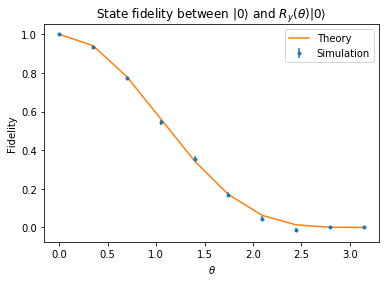

In [22]:
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="Simulation")
pyplot.plot(np.linspace(0, np.pi, points), (1/2+1/2*np.cos(np.linspace(0, np.pi, points)))**2, label="Theory")
pyplot.xlabel(r"$\theta$")
pyplot.ylabel("Fidelity")
pyplot.legend()
pyplot.title(r"State fidelity between $\left|0\right\rangle$ and $R_y(\theta)\left|0\right\rangle$")

### Monte-Carlo

In [23]:
points = 10
res = np.zeros(points)
res_std_err = np.zeros(points)
for (i,theta) in enumerate(np.linspace(0, np.pi, points)):
    zz_state_mc = generate_monte_carlo_state_dfe_experiment(p, [0,1], bm, n_terms=32)
    zz_state_mc.program = Program(RY(theta,0),RY(theta,1))
    zz_state_mc_data = acquire_dfe_data(qvm,zz_state_mc,n_shots=1000)
    est = estimate_dfe(zz_state_mc_data, 'state')
    res[i] = est.fid_point_est
    res_std_err[i] = est.fid_std_err

Text(0.5, 1.0, 'State fidelity between $\\left|0\\right\\rangle$ and $R_y(\\theta)\\left|0\\right\\rangle$')

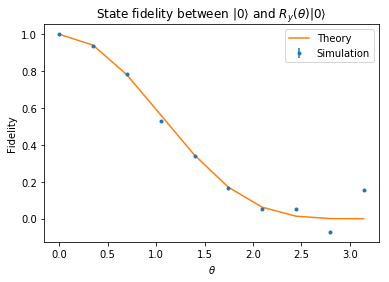

In [24]:
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="Simulation")
pyplot.plot(np.linspace(0, np.pi, points), (1/2+1/2*np.cos(np.linspace(0, np.pi, points)))**2, label="Theory")
pyplot.xlabel(r"$\theta$")
pyplot.ylabel("Fidelity")
pyplot.legend()
pyplot.title(r"State fidelity between $\left|0\right\rangle$ and $R_y(\theta)\left|0\right\rangle$")

## State fidelity between $\left|0\right\rangle\left|0\right\rangle$ and $R_y(\theta)\otimes R_y(2\theta)\left|0\right\rangle\left|0\right\rangle$

### Exhaustive

In [9]:
points = 20
res = np.zeros(points)
res_std_err = np.zeros(points)
for (i,theta) in enumerate(np.linspace(0, np.pi, points)): 
    zz_state.program = Program(RY(theta,0),RY(2*theta,1))
    zz_state_data = acquire_dfe_data(qvm,zz_state,n_shots=10_000)
    est = estimate_dfe(zz_state_data, 'state')
    res[i] = est.fid_point_est
    res_std_err[i] = est.fid_std_err

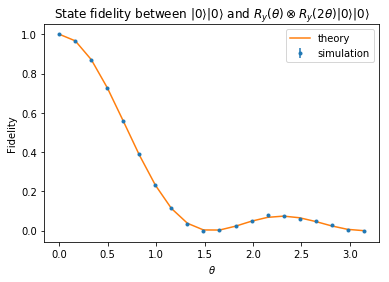

In [10]:
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="simulation")
pyplot.plot(np.linspace(0, np.pi, points), 
            (1/2+1/2*np.cos(np.linspace(0, np.pi, points)))*(1/2+1/2*np.cos(2*np.linspace(0, np.pi, points))),
            label="theory")
pyplot.xlabel(r"$\theta$")
pyplot.ylabel("Fidelity")
pyplot.legend()
pyplot.title(r"State fidelity between $\left|0\right\rangle\left|0\right\rangle$ and $R_y(\theta)\otimes R_y(2\theta)\left|0\right\rangle\left|0\right\rangle$");

### Monte Carlo

In [18]:
points = 20
res = np.zeros(points)
res_std_err = np.zeros(points)
for (i,theta) in enumerate(np.linspace(0, np.pi, points)): 
    zz_state_mc = generate_monte_carlo_state_dfe_experiment(p, [0,1], bm, n_terms=32)
    zz_state_mc.program = Program(RY(theta,0),RY(2*theta,1))
    zz_state_mc_data = acquire_dfe_data(qvm,zz_state_mc,n_shots=10_000)
    est = estimate_dfe(zz_state_mc_data, 'state')
    res[i] = est.fid_point_est
    res_std_err[i] = est.fid_std_err

Text(0.5, 1.0, 'State fidelity between $\\left|0\\right\\rangle\\left|0\\right\\rangle$ and $R_y(\\theta)\\otimes R_y(2\\theta)\\left|0\\right\\rangle\\left|0\\right\\rangle$')

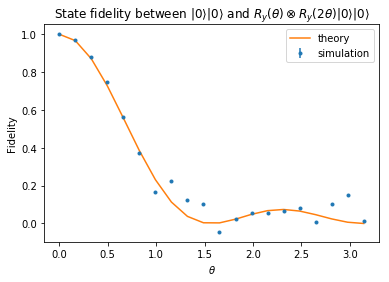

In [19]:
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="simulation")
pyplot.plot(np.linspace(0, np.pi, points), 
            (1/2+1/2*np.cos(np.linspace(0, np.pi, points)))*(1/2+1/2*np.cos(2*np.linspace(0, np.pi, points))),
            label="theory")
pyplot.xlabel(r"$\theta$")
pyplot.ylabel("Fidelity")
pyplot.legend()
pyplot.title(r"State fidelity between $\left|0\right\rangle\left|0\right\rangle$ and $R_y(\theta)\otimes R_y(2\theta)\left|0\right\rangle\left|0\right\rangle$")

## Process fidelity between $I\otimes I$ and $R_y(\theta)\otimes I$

In [25]:
%%time
p = Program(I(0))
ii_proc = generate_exhaustive_process_dfe_experiment(p, [0], bm)
ii_proc_mc = generate_monte_carlo_process_dfe_experiment(p, [0], bm, n_terms=32)

CPU times: user 15.8 ms, sys: 4.78 ms, total: 20.6 ms
Wall time: 113 ms


### Exhaustive

In [26]:
points = 20
res = np.zeros(points)
res_std_err = np.zeros(points)
for (i,theta) in enumerate(np.linspace(0, np.pi, points)): 
    ii_proc.program = Program(RY(theta,0))
    ii_proc_data = acquire_dfe_data(qvm,ii_proc,n_shots=500)
    est = estimate_dfe(ii_proc_data, 'process')
    res[i] = est.fid_point_est
    res_std_err[i] = est.fid_std_err

Text(0.5, 1.0, 'Process fidelity between $I\\otimes I$ and $R_y(\\theta)\\otimes I$')

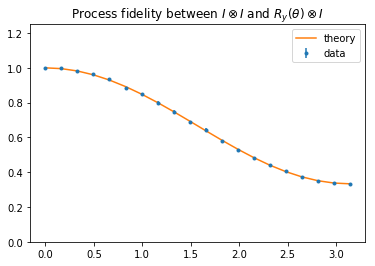

In [27]:
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="data")
pyplot.plot(np.linspace(0, np.pi, points), 
            (4*np.cos(np.linspace(0, np.pi, points)/2)**2+2)/6,
            label="theory")
#pyplot.axhline(0.2380952380952381+0.1, color="red", ls="--")
pyplot.legend()
pyplot.ylim(0,1.25)
pyplot.title(r"Process fidelity between $I\otimes I$ and $R_y(\theta)\otimes I$")

### Monte Carlo

In [28]:
points = 20
res = np.zeros(points)
res_std_err = np.zeros(points)
for (i,theta) in enumerate(np.linspace(0, np.pi, points)): 
    ii_proc_mc = generate_monte_carlo_process_dfe_experiment(p, [0], bm, n_terms=32)
    ii_proc_mc.program = Program(RY(theta,0))
    ii_proc_mc_data = acquire_dfe_data(qvm, ii_proc_mc, n_shots=500)
    est = estimate_dfe(ii_proc_mc_data, 'process')
    res[i] = est.fid_point_est
    res_std_err[i] = est.fid_std_err

Text(0.5, 1.0, 'Process fidelity between $I\\otimes I$ and $R_y(\\theta)\\otimes I$')

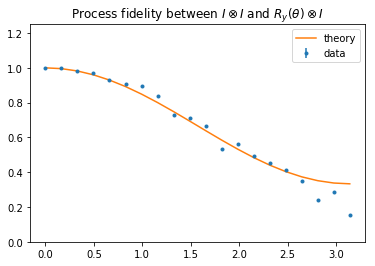

In [29]:
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="data")
pyplot.plot(np.linspace(0, np.pi, points), 
            (4*np.cos(np.linspace(0, np.pi, points)/2)**2+2)/6,
            label="theory")
pyplot.legend()
pyplot.ylim(0,1.25)
pyplot.title(r"Process fidelity between $I\otimes I$ and $R_y(\theta)\otimes I$")